In [2]:
# Functions from part1 are in util.py

# util.py functions:
#
# parse_data(filename) , parse_data_truth(filename)
# shingle_document(string,k)
# jaccard(string1,string2)
# processData(fileID,k)

from util import *

### Part 2A

In [3]:
def processShingles(fid,k):
    # given a file, will return a list of tuples of the form (docid, [shingles])
    data = []
    dt = parse_data(fid) # parse data
    
    for doc in dt:
        data.append((doc[0],shingle_document(doc[1],k)))

    return data

def invert_shingles(shingled_documents):
    items = [] # contains list of unique shingles
    data = [] # tuple list to return
    docs = [] # list of doc ids
    
    for doc in shingled_documents:
        docs.append(doc[0])
        for shingle in doc[1]:
            try:
                # check to see if shingle is already in our list
                idx = items.index(shingle)
                # if yes, just append the doc id to our tuple list
                data[idx][1].append(doc[0]) 
            except:
                # shingle not in our list, need to create new entry
                
                # add shingle to item list
                items.append(shingle)
                # add an entry to our tuple list
                data.append((shingle,[doc[0]]))
                
    idx = np.argsort(items) # sort shingles
    return [data[i] for i in idx], docs


#### Quick check for invert shingles


In [4]:
dat = [(1,[1,2,3]),(2,[91,4,1]),(3,[2,8,1])]
print invert_shingles(dat)

([(1, [1, 2, 3]), (2, [1, 3]), (3, [1]), (4, [2]), (8, [3]), (91, [2])], [1, 2, 3])


### Part 2B

In [5]:
import random

def make_random_hash_fn(p=2**33-355, m=4294967295):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m

def make_hashes(num_hash=1):
    h_functions = []
    for i in range(num_hash):
        h_functions.append(make_random_hash_fn())
    return h_functions

### Part 2C

In [6]:
import numpy

def make_minhash_signature(shingled_data, num_hashes):
    inv_index, docids_full = invert_shingles(shingled_data)
    num_docs = len(docids_full)

    # initialize the signature matrix with infinity in every entry
    sigmatrix = np.full([num_hashes, num_docs], np.inf)

    # generate hash functions
    hash_funcs = make_hashes(num_hashes)

    # iterate over each non-zero entry of the characteristic matrix
    for row, docids in inv_index: # for each row in characteristic matrix
        for docid in docids: # for each document in a row
            docid_idx = docids_full.index(docid) # find index of document in full list
            for i,hash_func in enumerate(hash_funcs): # for each hash function
                if sigmatrix[i,docid_idx] != 0: # only if sigmatrix value is not zero
                    if hash_func(row) < sigmatrix[i,docid_idx]:
                        sigmatrix[i,docid_idx] = hash_func(row)

    return sigmatrix, docids_full



### Part 2D

In [7]:
def minhash_similarity(id1, id2, minhash_sigmat, docids):
    # get column of the similarity matrix for the two documents
    id1_idx = docids.index(id1)
    id2_idx = docids.index(id2)
    
    # calculate the fraction of rows where two columns match
    return np.mean(minhash_sigmat[:,id1_idx] == minhash_sigmat[:,id2_idx])

### Part 2E

In [8]:
def processJsimMH(fid,k,numHashes):
    
    # get a list of tuples of the form (docid, [shingles])
    shingles = processShingles(fid,k)
    
    # create minhash signature from data
    mh_matrix, docids = make_minhash_signature(shingles,numHashes)
    
    data = []
    for dtpair in combinations(docids, 2):  # N choose 2 to loop through all pairs of doc ids
        
        # calculate minhash jsim estimate
        mhJsim = minhash_similarity(dtpair[0],dtpair[1], mh_matrix, docids)
        
        # add to data
        data.append((dtpair[0],dtpair[1],mhJsim))
        
    return data

### PART 2F

- Generate data and save to memory

I am going to assume a fixed shingle length and vary number of hashes

In [81]:
import time

fname = 'data/articles_1000.train'
k = 4
numHashes = [1,5,10,50,100,500,1000,10000]
mhsims = []

if 0:
    for numHash in numHashes:
        start_time = time.time()
        mhsims.append(processJsimMH(fname,k,numHash))
        print ' --- '+str(time.time()-start_time)+' seconds --- | Hashes = '+str(numHash)+' / '+str(numHashes[-1])
        # save data every iteration
        np.save('data_gen/data_1000_part2_hashes.npy',mhsims)
else:
    mhsims = np.load('data_gen/data_1000_part2_hashes.npy')

- Load known Jaccard sim values from part 1 and calculate RMS error

In [80]:
jsims = np.load('data_gen/data_1000.npy')
k = 4
rms_errs = []

for j in range(len(mhsims)): # for each hash
    rms_err = 0
    for i in range(len(jsims)): # for each doc pair
        # calculate rms error
        rms_err += (float(jsims[k-1][i][2]) - float(mhsims[j][i][2]))**2
        
    rms_err = np.sqrt(rms_err/len(jsims[k-1]))
    rms_errs.append(rms_err)

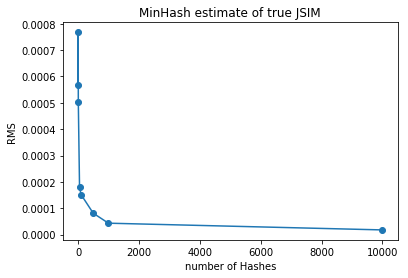

In [79]:
import matplotlib.pyplot as plt

plt.plot(numHashes,rms_errs,marker='o')

plt.title('MinHash estimate of true JSIM')
plt.ylabel('RMS')
plt.xlabel('number of Hashes')

plt.show()